In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from typing import TypedDict, Literal
from pydantic import BaseModel, Field

In [2]:
model = ChatOllama(model='llama3.1:8b')

In [3]:
# We want structured output thats why i want to create structured schema

class SentimentSchema(BaseModel):
    sentiment: Literal['positive','negative'] = Field(description='Sentiment of the review')
    

In [4]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [5]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [6]:
class ReviewState(TypedDict):
    
    review : str
    sentiment : Literal['positive', 'negative']
    diagnosis : dict
    response : str
    
    

In [7]:

def find_sentiment(state: ReviewState):

    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = structured_model.invoke(prompt).sentiment

    return {'sentiment': sentiment}

def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:

    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
def positive_response(state: ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website."""
    
    response = model.invoke(prompt).content

    return {'response': response}

def run_diagnosis(state: ReviewState):

    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = structured_model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState):

    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}

In [8]:
graph = StateGraph(ReviewState)

#add nodes
graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_dignosis', run_diagnosis)
graph.add_node('negative_response', negative_response)
# add edges
graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

In [9]:
workflow = graph.compile()

ValueError: Found edge starting at unknown node 'run_diagnosis'

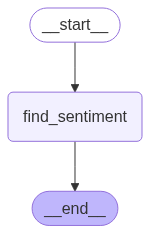

In [ ]:
workflow

In [ ]:
initial_state = {
    'review' : 'The product was really bad'
}

workflow.invoke(initial_state)

{'review': 'The product was really bad', 'sentiment': 'negative'}